In [27]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow import keras

from IPython.display import clear_output

In [28]:
applications = pd.read_excel('Big_Case_-_nubank_v2.1.xlsx', sheet_name='application_data')

In [29]:
applications = pd.concat([applications, pd.get_dummies(applications['residence_duration'], prefix='residence').astype(int)], axis=1)
applications = pd.concat([applications, pd.get_dummies(applications['bank_account_duration'], prefix='bank').astype(int)], axis=1)
applications = pd.concat([applications, pd.get_dummies(applications['facebook_profile_duration'], prefix='fb').astype(int)], axis=1)
applications = pd.concat([applications, pd.get_dummies(applications['home_phone_type'], prefix='phone').astype(int)], axis=1)

applications['age_when_requested'] = (applications['application_when'] - applications['birth_date']).apply(lambda x: x.days//365)
applications['residence_rent_or_own'] = applications['residence_rent_or_own'].astype(int)


applications = applications.drop(columns=['first_name', 'middle_initial', 'last_name', 'address_street', 'cep',
                                          'longitude', 'latitude', 'address_state', 'birth_date', 'facebook_profile_duration',
                                          'residence_duration', 'bank_account_duration', 'facebook_gender', 'home_phone_type',
                                          'address_city', 'phone', 'email', 'occupation', 'cpf',])

In [30]:
performance = pd.read_excel('Big_Case_-_nubank_v2.1.xlsx', sheet_name='performance_data')

# Definindo as variáveis Defaulted e Compliant como binárias e opostas
performance['defaulted'] = performance['defaulted'].astype(int)
performance['compliant'] = np.abs(1-performance['defaulted'])

In [31]:
clients_data = pd.merge(applications, performance, on='id')

# Arrumando o nome das colunas 
clients_data.columns = clients_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '_').str.replace('+', '')


In [33]:
# Definimos o tempo como cliente 
clients_data['time_as_client'] = (clients_data['customer_until']-clients_data['application_when']).apply(lambda x: np.ceil(x.days/30) if not isinstance(x, type(pd.NaT)) else -1)
# assumimos um efeito lindy para o tempo total de clientes que ainda são clientes
clients_data['time_as_client'] = clients_data['time_as_client'].replace([-1], max(clients_data['time_as_client'])*2)
clients_data['monthly_income'] = (clients_data['monthly_spend']+clients_data['monthly_rent'])/np.random.normal(0.8, 0.1, len(clients_data))
clients_data = clients_data.drop(columns=['customer_until'])

In [34]:
# Situação impossível: sem gastos porém marcado como inadimplente
indexes_to_filter = clients_data[(clients_data.monthly_spend == 0) & (clients_data.defaulted == 1)].index
clients_data = clients_data.drop(indexes_to_filter)


In [35]:
clients_data = clients_data.replace([-np.inf, np.inf], np.nan)
clients_data = clients_data.dropna()

### Definição do lucro mensal por cliente

Dados que temos o tempo em que um indivíduo permanece como cliente e o seu gasto mensal médio, podemos calucular o lucro cliente como:

L = (Tempo como Cliente * Gasto Mensal * Taxa do cartão) - (B_Inad * Gasto Mensal)

Onde B_Inad é uma variável booleana que representa 1 se o cliente entrou em inadimplência. Assim, estimamos que a perda por um cliente inadimplente é a média do seu gasto mensal

Assumimos, também, um **efeito lindy** para o tempo total que um cliente atual será cliente. Assim, assumindo que os clientes mais longevos tem o cartão há aproximadamente 51 meses, esperamos que eles sejam cliente por mais 51 meses  

In [36]:
fee = 2/100

clients_data['profit'] = (clients_data['time_as_client']*clients_data['monthly_spend']*fee - clients_data['defaulted']*clients_data['monthly_spend'])

In [37]:
clients_data[['defaulted', 'monthly_spend', 'time_as_client', 'profit']].groupby('defaulted').mean()

,monthly_spend,time_as_client,profit
defaulted,,,
0,1002.469752,90.986618,1818.859016
1,1053.949902,10.404715,-839.305403


Ou seja, na média, para clientes adimplentes, esperamos receber aproximadamente 1820 e para clientes inadimplentes, aproximadamente 840

### Em caso de calote, quanto é o valor esperado da perda? 

### Por quanto tempo temos o cliente? 

### Qual o ganho esperado por cliente dado seu calote ou não?

In [38]:
clients_data[['defaulted', 'monthly_spend', 'time_as_client', 'profit']].corr()

,defaulted,monthly_spend,time_as_client,profit
defaulted,1.000000,0.018679,-0.805326,-0.487055
monthly_spend,0.018679,1.000000,-0.020534,0.585130
time_as_client,-0.805326,-0.020534,1.000000,0.520707
profit,-0.487055,0.585130,0.520707,1.000000


In [39]:
clients_data[['defaulted', 'monthly_spend', 'time_as_client', 'profit']].describe().T

,count,mean,std,min,25%,50%,75%,max
defaulted,9210.0,0.221064,0.414986,0.00,0.00,0.00,0.00,1.00
monthly_spend,9210.0,1013.850163,1143.705247,0.00,288.00,742.00,1361.00,23074.00
time_as_client,9210.0,73.172856,41.524014,1.00,21.00,102.00,102.00,102.00
profit,9210.0,1231.234395,2264.836978,-12622.18,36.72,681.36,2172.09,30920.28


### Problema de negócio:

#### Desenvolver um modelo de decisão de aceitar um pedido de cartão de crédito baseado em informações pessoais e financeiras de cliente

Hoje, aproximadamente 22% dos usuários tornam-se inadimplentes. Sendo assim, utilizando as premissas citadas acima, para 1000 pedidos de cartão, podemos calcular o valor esperado de lucro como:

$E[L] = 1000*(0.88*1818 - 0.22*834) = 1.416.360$

Se pudermos classificar os novos pedidos de cartão e filtrar aqueles com alta probabilidade de inadimplência, podemos diminuir a taxa de inadimplência de 22% e aumentar a taxa de adimplência de 88%.

Nas métricas de classificação, todos os pedidos classificados como Positivo referem-se a um cliente **COMPLIANT**, ou seja, aquele que NÃO deixou de honrar suas dívidas (o oposto de DEFAULT). Assim, temos:

 - True Positive: Cliente classificado como COMPLIANT e que não deixa de pagar a fatura (Receita, $E[X]=1818$)
 - False Positive: Cliente classificado como COMPLIANT mas que vem a deixar de pagar a fatura (Potencial Prejuízo, $E[X] = -834$)
 - True Negative: Cliente classificado como NÃO-COMPLIANT e que de fato viria a deixar de pagar a fatura (Evita-se o prejuízo, $E[X] = 0$)
 - False Negative: Cliente classificado como NÃO-COMPLIANT e que não deixaria de pagar a fatura (Perda de potencial receita, $E[X] = 0$)

Ou seja, os clientes classificados como Positive receberão cartão (Profit > 0), e os classificados como Negative terão seu pedido negado (Profit < 0).

Assim, a decisão final se dará no lucro esperado para cada cliente. Para isso serão necessários três modelos adicionais:
- Um modelo de regressão para estimar o gasto mensal esperado por cliente
- Um modelo de regressão para estimar o tempo que um cliente será cliente
- Um modelo classificador para estimar se um cliente será inadimplente ou não

Com essas três informações em mãos, podemos criar o modelo final. A matrix de confuão a seguir demonstra os valores esperados para cada decisão

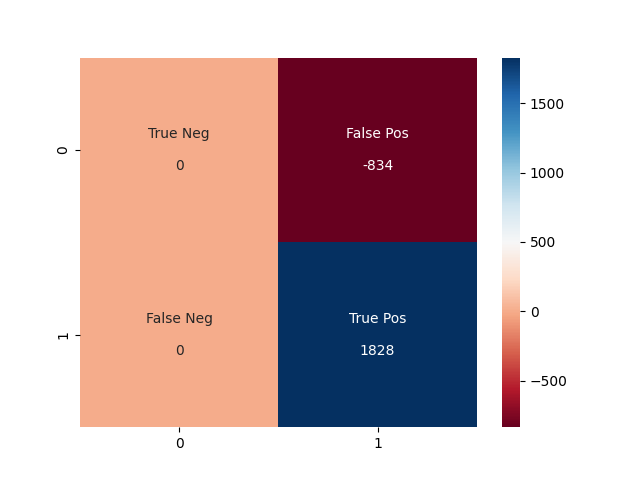

In [40]:
# clients_data = pd.concat([clients_data[clients_data.defaulted==True].sample(2000), 
#                           clients_data[clients_data.defaulted==False].sample(2000)])
clients = deepcopy(clients_data)

# clients['monthly_income'] = np.log10(np.array(clients['monthly_income'] + 1))
# clients['monthly_rent'] = np.log10(np.array(clients['monthly_rent'] + 1))
# clients['credit_line_approved'] = np.log10(np.array(clients['credit_line_approved'] + 1))
# clients['credit_line_requested'] = np.log10(np.array(clients['credit_line_requested'] + 1))
# clients['monthly_spend'] = np.log10(np.array(clients['monthly_spend'] + 1))

clients['residence_rent_or_own'] = clients['residence_rent_or_own'].astype('int')
clients['defaulted_int'] = clients.defaulted.astype('int')

clients['free_cash_flow'] = clients['monthly_income']-clients['monthly_rent']
clients['app_req_ratio'] = clients['credit_line_approved']/clients['credit_line_requested']
clients['approved_income_ratio'] = clients['credit_line_approved']/clients['monthly_income']

#normalize credit scores
# clients[['score_tu', 'score_fico_money', 'score_lexisnexis', 'score_serasa', 'score_unit4']] = MinMaxScaler().fit_transform(clients[['score_tu', 'score_fico_money', 'score_lexisnexis', 'score_serasa', 'score_unit4']])

In [41]:
personal_data = [
    'age_when_requested', 'residence_1_2_years', 'residence_3_years', 
    'residence_6_months_or_less', 'residence_7_12_months',]
                  
bank_data = [
    'bank_1_2_years','bank_3_years', 'bank_6_months_or_less', 'bank_7_12_months',]

financial_data = [
    'monthly_income', 'monthly_rent', 'residence_rent_or_own',
    'free_cash_flow', 'approved_income_ratio']

credit_score_data = [
    'score_tu', 'score_fico_money', 'score_lexisnexis', 'score_serasa', 
    'score_unit4', 'credit_line_requested', 'credit_line_approved','app_req_ratio']

target = ['compliant', 'monthly_spend', 'time_as_client', 'profit']

selected_features = [
    'residence_1_2_years', 'residence_3_years', 
    'residence_6_months_or_less', 'residence_7_12_months',
    'bank_1_2_years','bank_3_years', 'bank_6_months_or_less', 'bank_7_12_months',
    'monthly_income', 'monthly_rent', 'residence_rent_or_own',
    'free_cash_flow', 'approved_income_ratio',
    'score_tu', 'score_fico_money', 'score_lexisnexis', 'score_serasa', 
    'score_unit4', 'credit_line_requested', 'credit_line_approved','app_req_ratio',
]

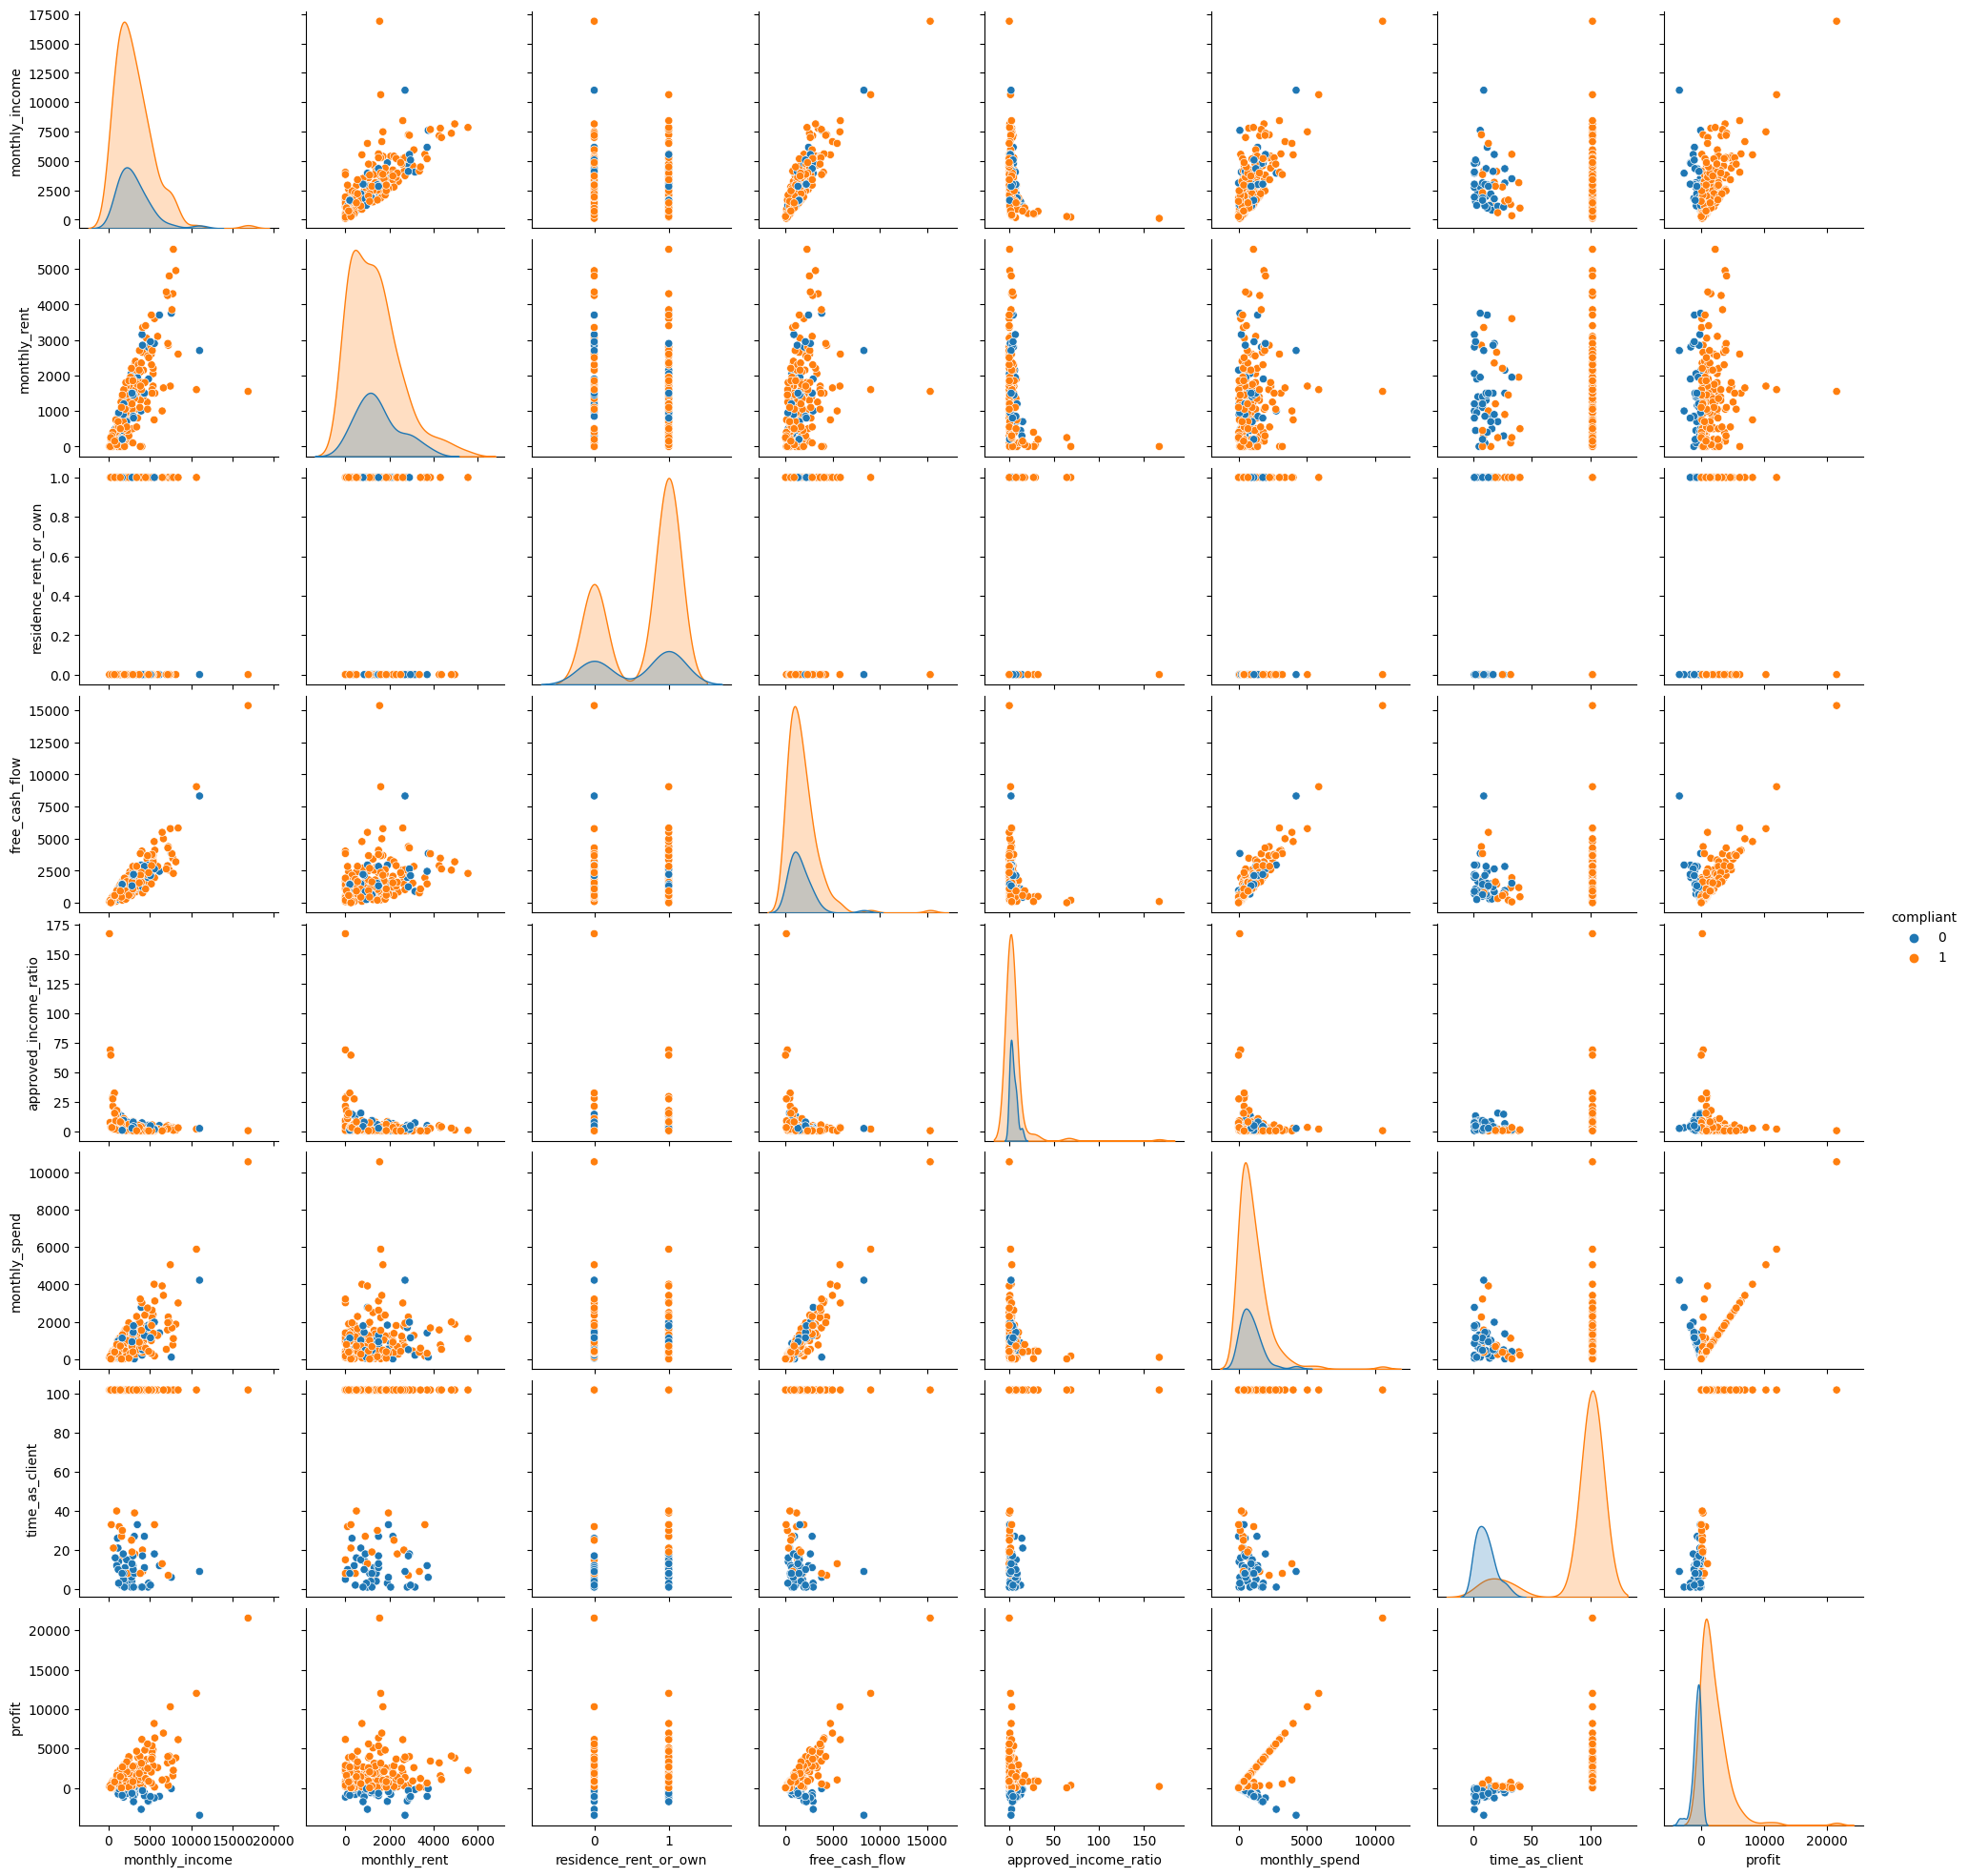

In [42]:
sns.pairplot(clients.sample(200)[financial_data + target], hue='compliant')
plt.savefig('financial_data_pairplot.png')

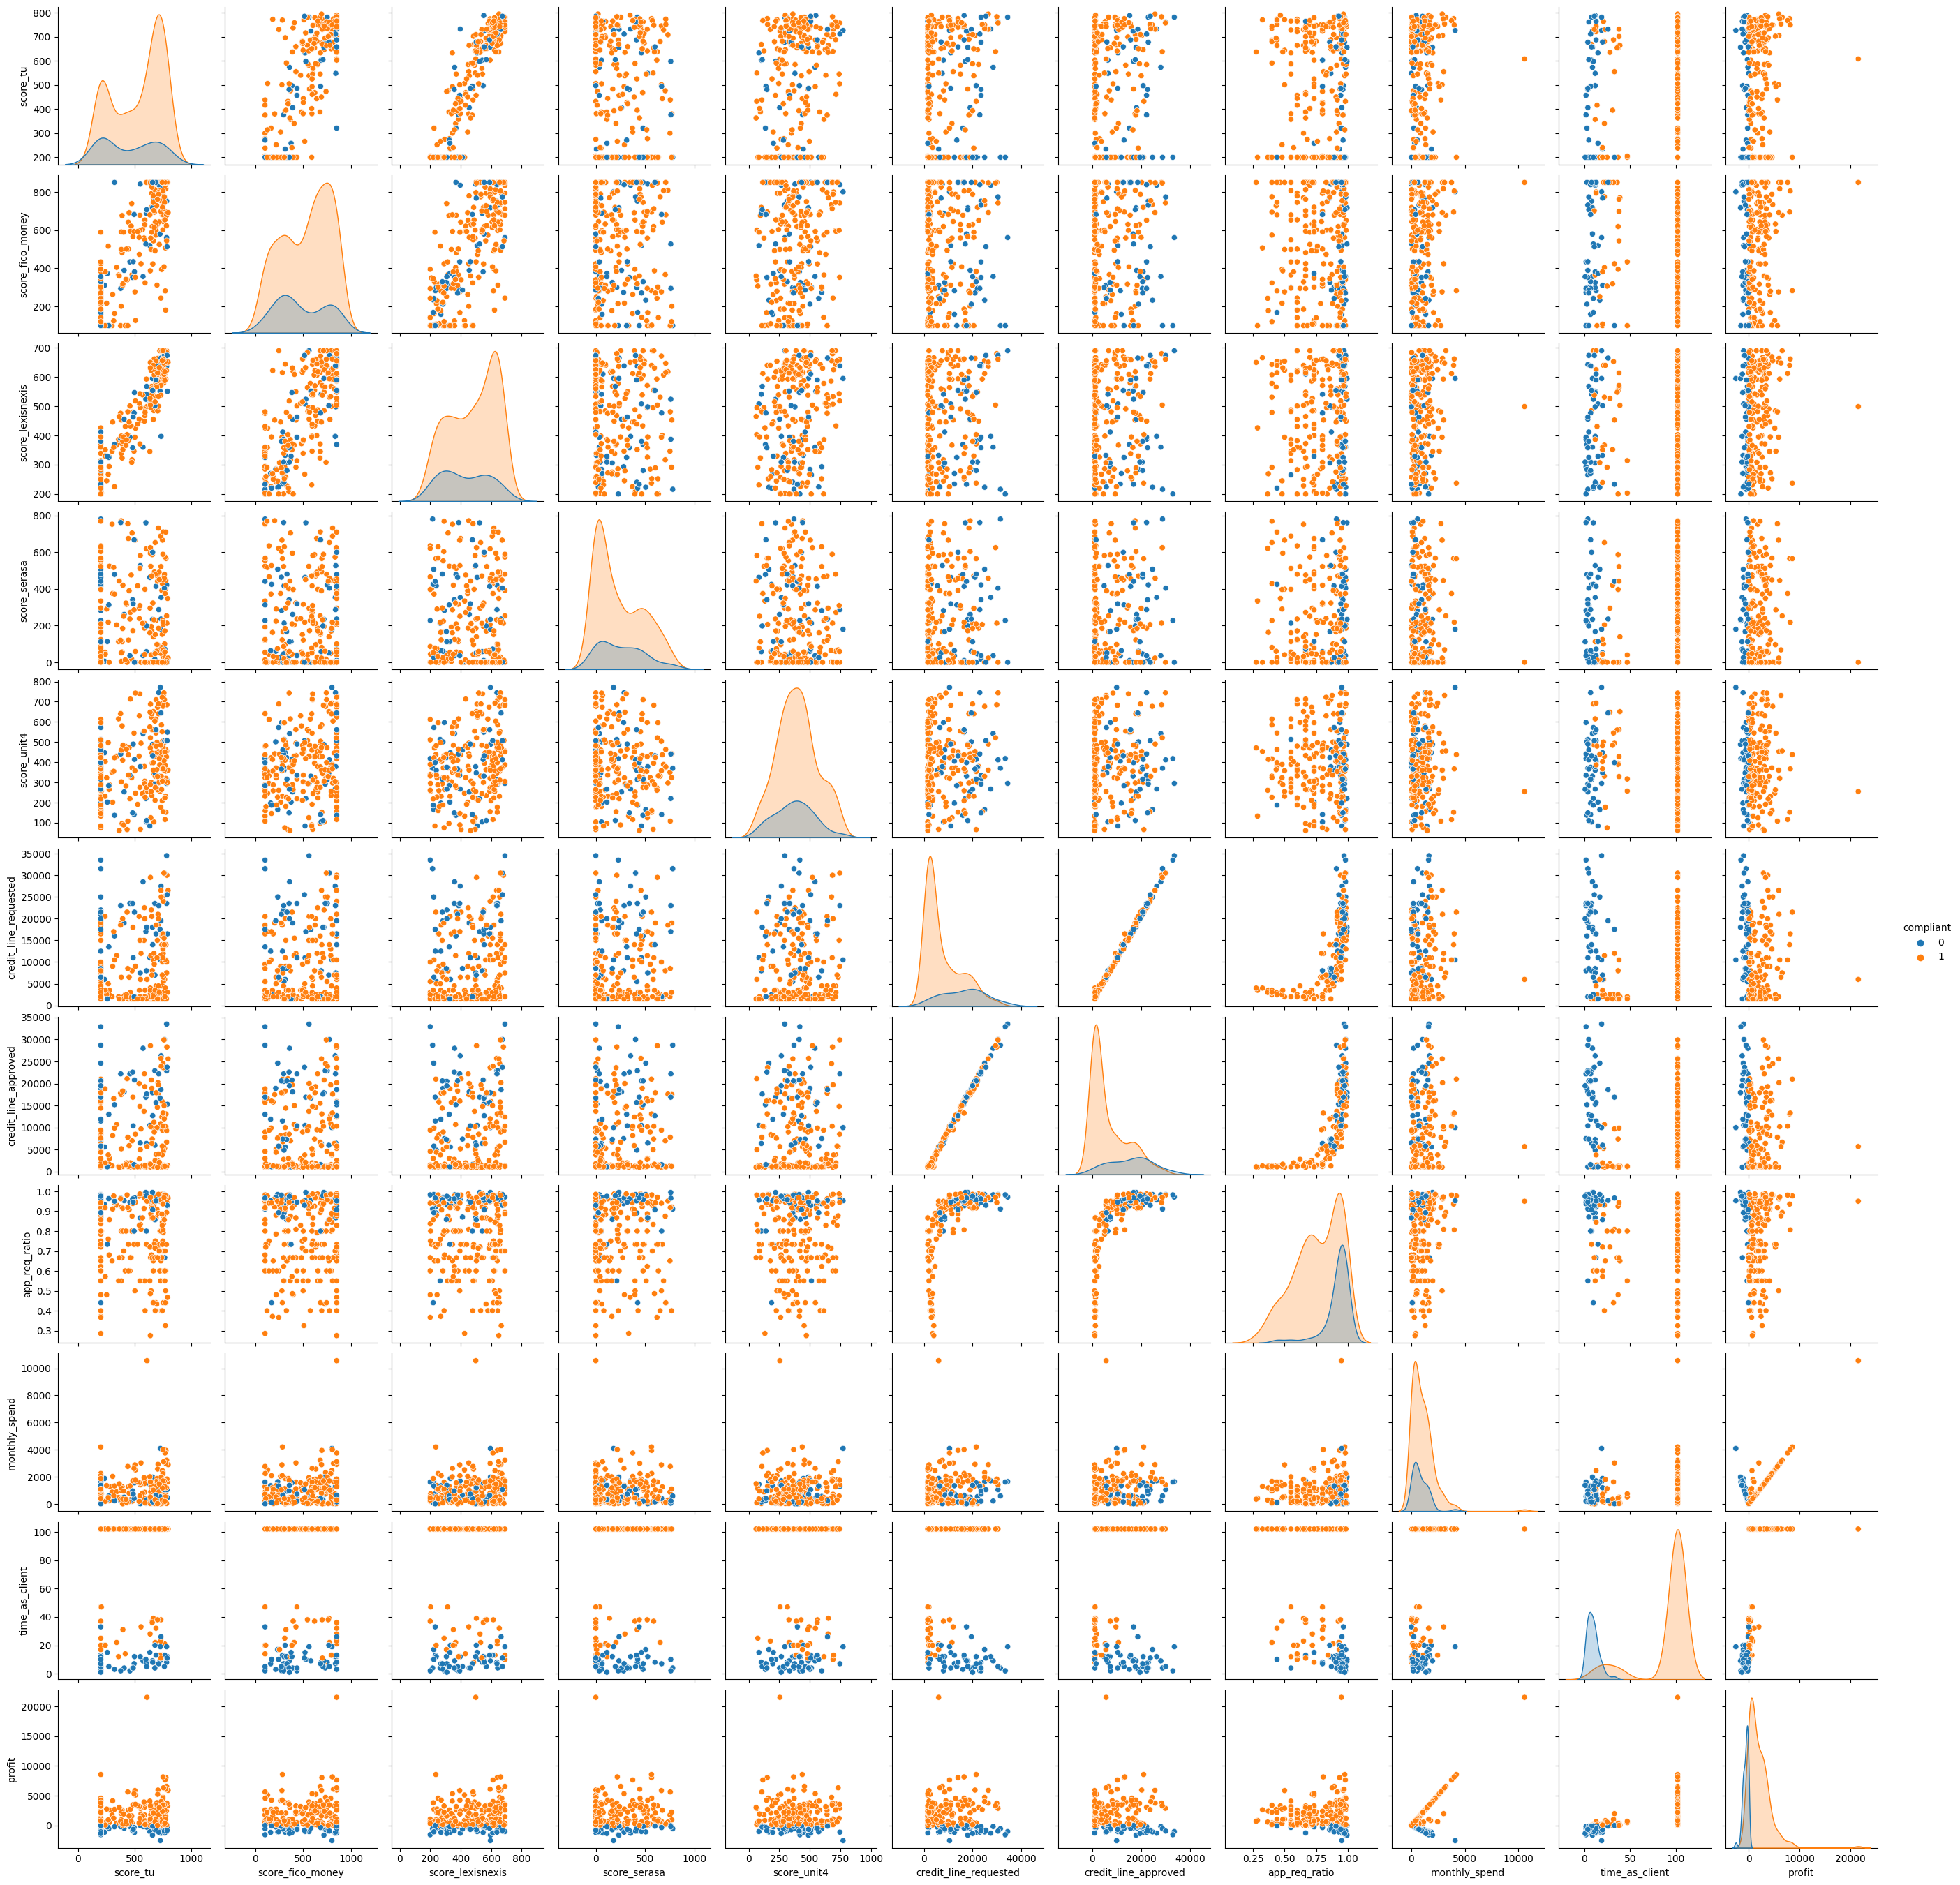

In [20]:
sns.pairplot(clients.sample(250)[credit_score_data + target], hue='compliant')
plt.savefig('credit_score_data_pairplot.png')


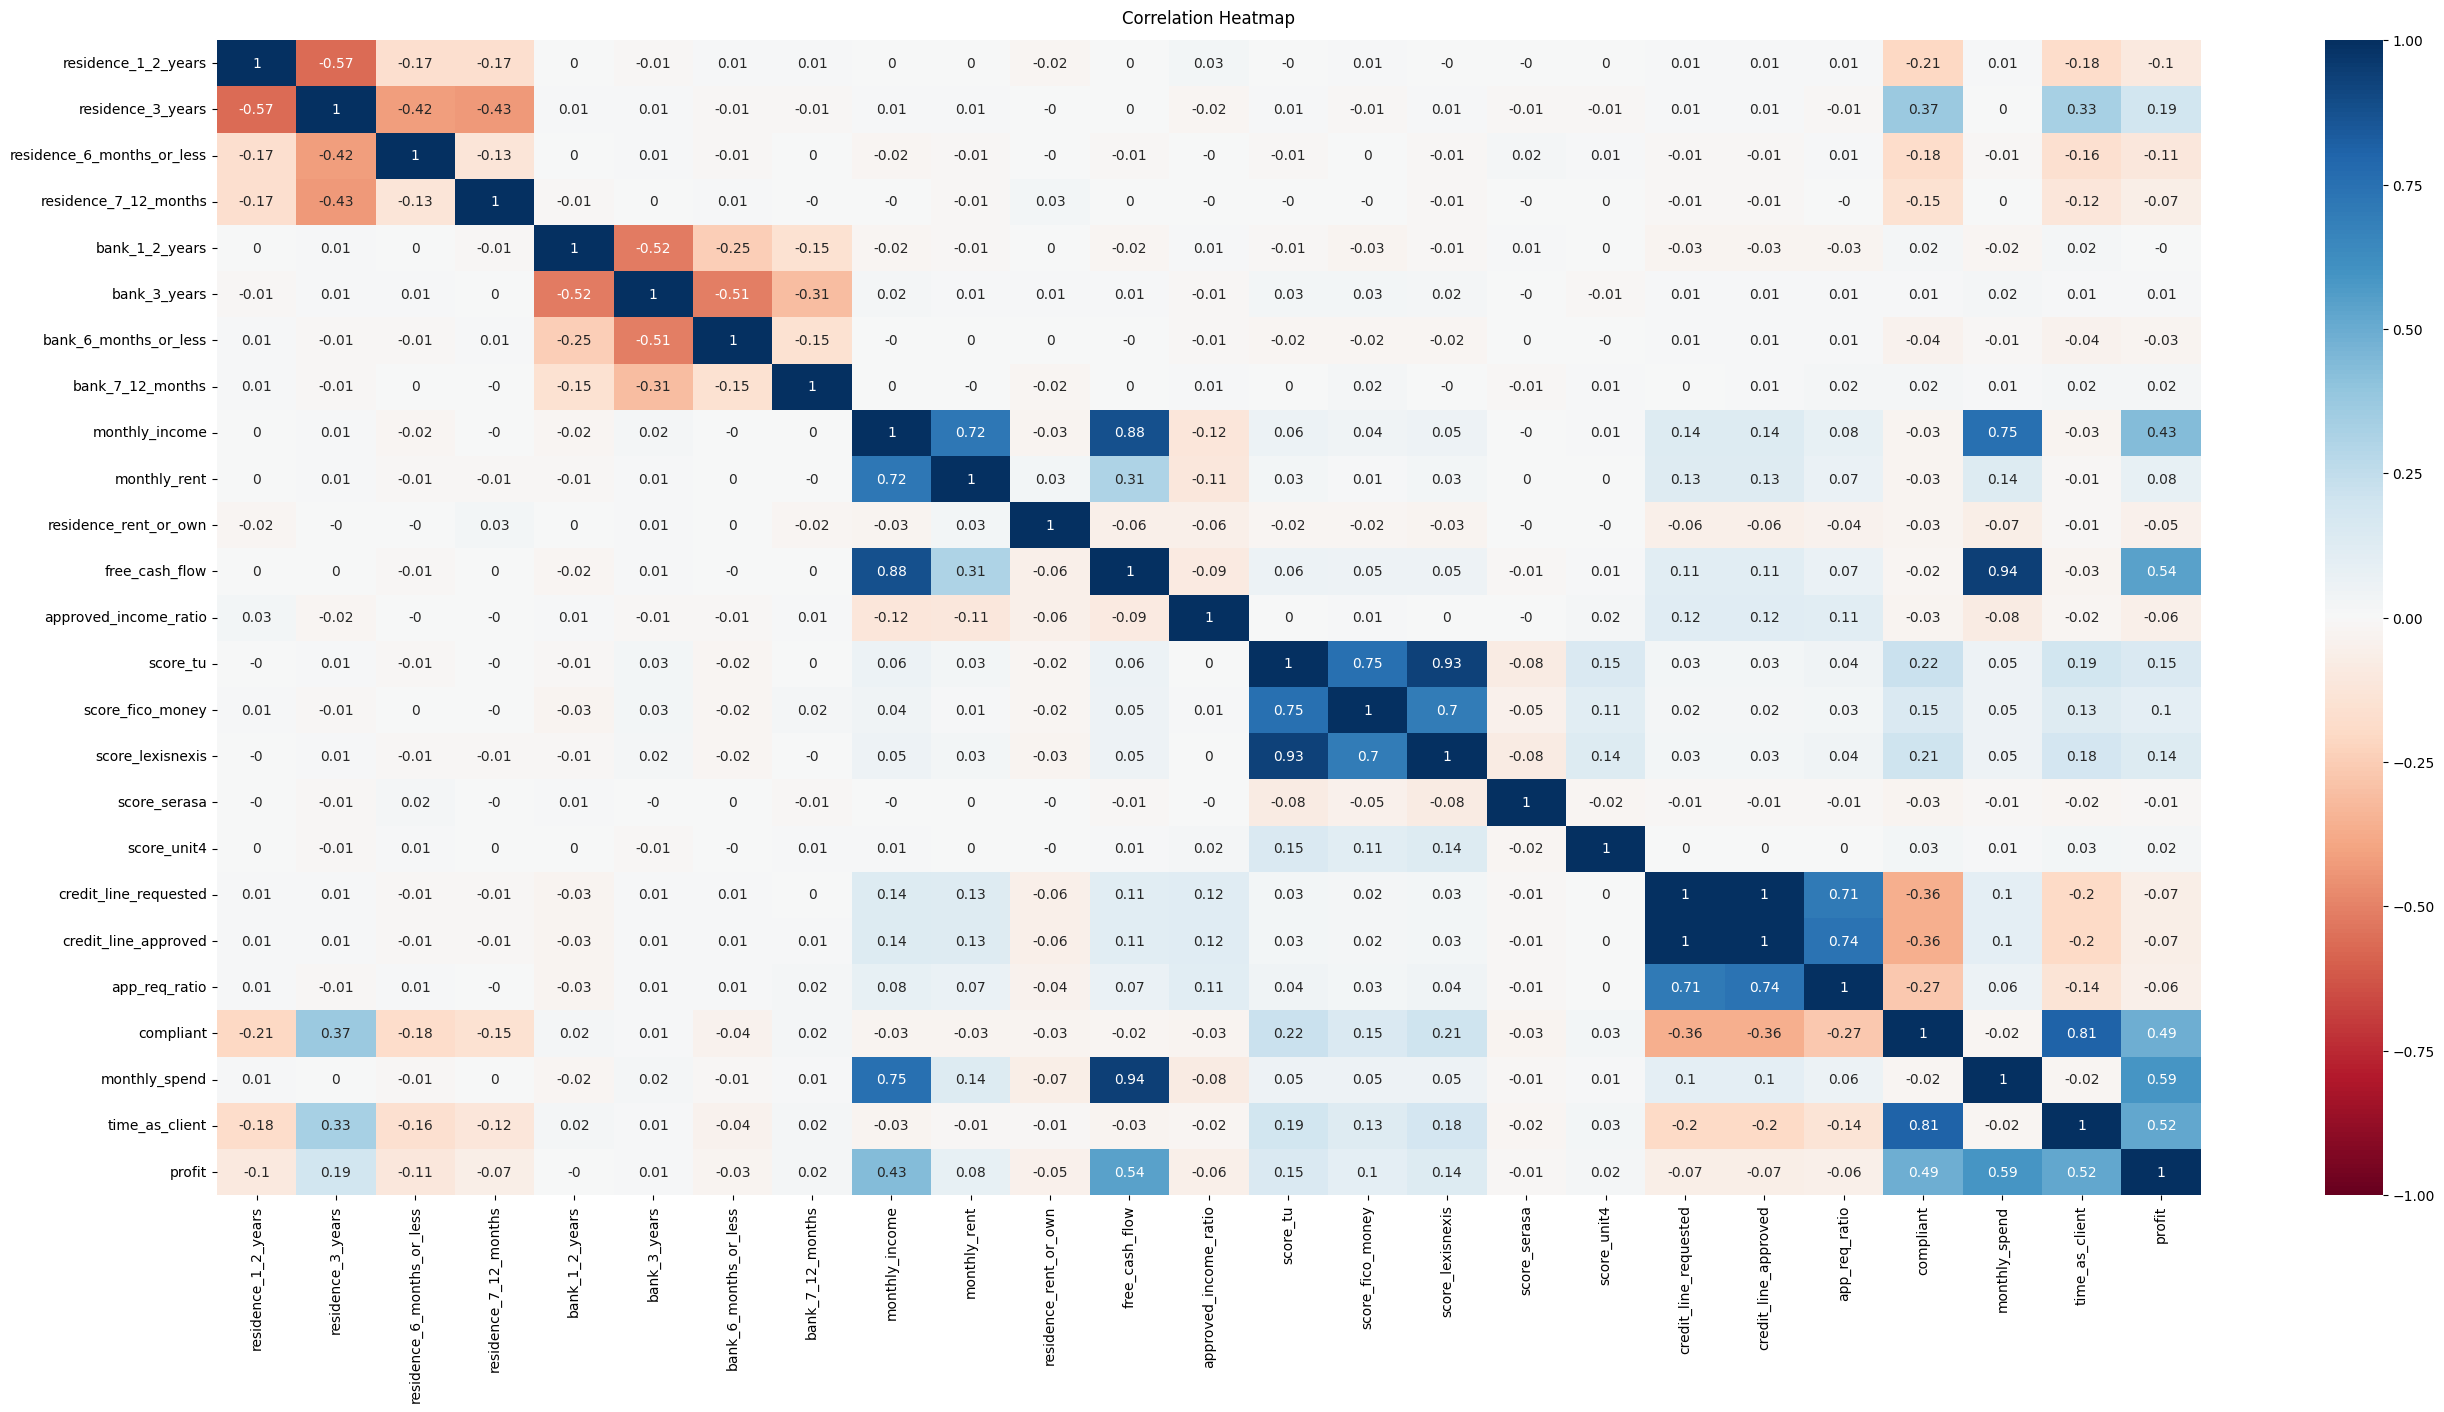

In [43]:
# Increase the size of the heatmap.
plt.figure(figsize=(32, 15))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(clients[selected_features+target].corr().round(2), vmin=-1, vmax=1, annot=True, cmap='RdBu')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [44]:
final_df = deepcopy(clients[selected_features+target])
final_df = final_df.replace([-np.inf, np.inf], np.nan)
final_df = final_df.dropna()
final_df.to_json('final_data.json')

testing_df = final_df.sample(1000, random_state=12)
train_df = final_df.drop(testing_df.index)

testing_df.to_json('test_data.json')
train_df.to_json('train_data.json')